<h1><center> Kaggle Competition: [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)</center></h1> 

# 1. Data Ingestion & Data Cleaning

## 1.1 Data Ingestion

In [1]:
import math
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import subprocess
import seaborn as sns
sns.set()

import time
start_time = time.time()

In [2]:
# train_rows = 55423857
# print (f'>>> Exact number of rows: {train_rows}')

try:
    train_df = pd.read_csv('data/train.csv', nrows=5)
except FileNotFoundError:
    print('>>> You must download train.csv from: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/download/train.csv')

### Decrease memory footprint

In [3]:
# set column types to optimize memory usage
col_types = {
    'fare_amount': 'float32',
    'pickup_datetime': 'str', 
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'uint8'
}

new_cols = list(col_types.keys())

In [4]:
def get_raw_dataframe(read_size=0):   
    # Method #1: read the entire DataFrame from the disk
    if (read_size == 0):
        df_list = [] # list to hold the batch dataframe
        for df_chunk in tqdm(pd.read_csv('data/train.csv', usecols=new_cols, dtype=col_types, chunksize=5000000)): # loads 5M rows each iteration
            df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
            df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

            # Can process each chunk of dataframe here
            # clean_data(), feature_engineer(),fit()

            # Alternatively, append the chunk to list and merge all
            df_list.append(df_chunk) 

        # merge all dataframes into one
        train_df = pd.concat(df_list)
        del df_list
        return train_df
        
    # Method #2: read a predetermined amount of data         
    train_df = pd.read_csv('data/train.csv', usecols=new_cols, dtype=col_types, nrows=read_size)
    train_df['pickup_datetime'] = train_df['pickup_datetime'].str.slice(0, 16)
    train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    return train_df

In [5]:
# train_df.info(memory_usage='deep')

## 1.2 Data Cleaning

In [6]:
# check feature statistics
pd.set_option('float_format', '{:f}'.format) # prints the entire number instead of x + ye
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,8.020000,-73.959664,40.739009,-73.952068,40.757340,1.200000
std,5.102156,0.066789,0.024756,0.063357,0.029084,0.447214
min,4.500000,-74.016048,40.711303,-73.991567,40.712278,1.000000
25%,5.300000,-73.987130,40.721319,-73.991242,40.750562,1.000000
50%,5.700000,-73.982738,40.733143,-73.979268,40.758092,1.000000
75%,7.700000,-73.968095,40.761270,-73.956655,40.782004,1.000000
max,16.900000,-73.844311,40.768008,-73.841610,40.783762,2.000000


In [7]:
def get_clean_dataframe(num_rows):
    train_df = get_raw_dataframe(num_rows)
    
    # remove NaNs and Negative & Free fares (keeping only the ones that cost more than 0)
    train_df.dropna(inplace=True, axis=0)
    train_df = train_df[train_df['fare_amount'] > 0]

    # remove rows where lat/long are ZERO
    train_df = train_df[(train_df['pickup_latitude'] != 0) & (train_df['pickup_longitude'] != 0)]
    train_df = train_df[(train_df['dropoff_latitude'] != 0) & (train_df['dropoff_longitude'] != 0)]

    # handle rides with too many or too few passengers
    train_df = train_df[(train_df['passenger_count'] > 0) & (train_df['passenger_count'] <= 7)]
    return train_df

# 2. Feature Engineering

In [8]:
# Distance formula: https://www.movable-type.co.uk/scripts/latlong.html
def getDistance(lat1, lon1, lat2, lon2): 
    R = 6371e3
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    deltaPhi = math.radians(lat2-lat1)
    deltaLambda = math.radians(lon2-lon1)

    a = math.sin(deltaPhi/2) * math.sin(deltaPhi/2) + math.cos(phi1) * math.cos(phi2) * math.sin(deltaLambda/2) * math.sin(deltaLambda/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return round((R * c) / 1000, 3)    # returns distance in km

In [9]:
# Add calendar related features: year, month, day, hour, day_of_week
def add_calendar(df):
    df['year'] = df.pickup_datetime.apply(lambda x: x.year)
    df['month'] = df.pickup_datetime.apply(lambda x: x.month)
    df['day'] = df.pickup_datetime.apply(lambda x: x.day)
    df['hour'] = df.pickup_datetime.apply(lambda x: x.hour)
    df['day_of_week'] = df.pickup_datetime.apply(lambda x: x.weekday())

    df['year'] = df['year'].astype('int16')
    df['month'] = df['month'].astype('int8')
    df['day'] = df['day'].astype('int8')
    df['hour'] = df['hour'].astype('int8')
    df['day_of_week'] = df['day_of_week'].astype('int8')    
    return df

In [10]:
# Add distance in kilometers
def add_distance(df):
    df['distance_km'] = df.apply(lambda row: getDistance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    df['distance_km'] = df['distance_km'].astype('float32')

    df['distance_km_round'] = df.distance_km.apply(lambda x: int(round(x)))
    df['distance_km_round'] = df['distance_km_round'].astype('int16')
    return df

In [11]:
# Add geographical cluster as feature 
from sklearn.cluster import KMeans

# When this function is called with 1 arg, the arg is the training dataset. 
# When called with both args, the 1st arg is the test and the 2nd is the training dataset.
def add_geo_cluster(df, train=pd.DataFrame()):
    kmeans_geo_model = KMeans(n_clusters=4) # 4 clusters, as indicated by the Elbow method
    
    # The test and training datasets are passed so they can be clustered together and the test gets proper labels.
    if (not train.empty):
        df['is_test'] = 1
        train['is_test'] = 0
        geo_df = pd.concat([df,train], axis=0)[['pickup_longitude','pickup_latitude','is_test']]
    else:  
        geo_df = df[['pickup_longitude','pickup_latitude']]
        
    kmeans_geo_model.fit(geo_df[['pickup_longitude','pickup_latitude']])        
    cluster_labels = kmeans_geo_model.predict(geo_df[['pickup_longitude','pickup_latitude']])    
    geo_df['geo_cluster'] = cluster_labels
    
    if (train.empty):
        df['geo_cluster'] = cluster_labels    
        return df 
        
    df['geo_cluster'] = geo_df[geo_df['is_test'] == 1].geo_cluster
    train.drop('is_test', axis=1, inplace=True)
    df.drop('is_test', axis=1, inplace=True)  
    return df

In [12]:
# Add geographical distance as feature 
def add_geo_diff(df):
    df['lon_diff'] = df['dropoff_longitude'] - df['pickup_longitude']
    df['lat_diff'] = df['dropoff_latitude']  - df['pickup_latitude']
    return df

In [13]:
# Add number of taxis per hour (only works for the training set)
def add_taxis_per_hour(df):
    tmp = df.groupby(['year','month','day']).agg({'hour' : [np.size]}).reset_index()
    tmp.columns = ['year','month','day','taxis_per_hour']
    df = pd.merge(df, tmp, how='left', on=['year','month','day'])
    df['taxis_per_hour'] = df['taxis_per_hour'].astype('float32')
    return df

In [14]:
# Add mean/median/min/max fare (only works for the training set)
def add_fare_statistics(df):
    tmp = df.groupby(['year','month','day_of_week','hour','distance_km_round','taxis_per_hour']).agg({'fare_amount' : [np.mean,np.median,np.min,np.max]}).reset_index()
    tmp.columns = ['year','month','day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']
    df = pd.merge(df, tmp, how='left', on=['year','month','day_of_week','hour','distance_km_round','taxis_per_hour']) 
    return df

In [15]:
# Add Cost per KM (only works for the training set)
def add_cost_per_km(df):
    df['cost_per_km'] = df.apply(lambda row: row['distance_km_round'] / row['fare_amount'], axis=1)    
    df['cost_per_km'] = df['cost_per_km'].astype('float32')
    return df

# 3. Model Training

In [16]:
%%time

train_df = get_clean_dataframe(2000000) # loads 2M rows
# train_df = get_clean_dataframe(4000000) # loads 4M rows

train_df = add_calendar(train_df)
train_df = add_distance(train_df)
train_df = add_geo_diff(train_df)
train_df = add_taxis_per_hour(train_df)
train_df = add_fare_statistics(train_df)
train_df = add_cost_per_km(train_df)

Wall time: 4min 54s


In [17]:
# Plot Elbow
# from scipy.spatial.distance import cdist

# matrix_df = train_df[['pickup_longitude','pickup_latitude']]
# k_vector = range(3, 12)
# ss_vector = []

# # apply a new KMeans() for each k value in k_vector
# for k in k_vector:
#     model = KMeans(n_clusters=k)    
#     model.fit(matrix_df)
    
#     # compute Elbow SS Method
#     ss = sum(np.min(cdist(matrix_df, model.cluster_centers_, 'euclidean'), axis=1)) / matrix_df.shape[0]
#     #ss = model.inertia_ # alternative to SS
#     ss_vector.append(ss)    
    
# # Plot ks vs inertias
# plt.figure(figsize=(14,10))
# plt.plot(k_vector, ss_vector, '-o')
# plt.xlabel('Number of Clusters (K)')
# plt.ylabel('Elbow SS Method')
# plt.xticks(k_vector)
# plt.show()

In [18]:
train_df = add_geo_cluster(train_df)
display(train_df.head())

C:\Users\brcod\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,...,distance_km_round,lon_diff,lat_diff,taxis_per_hour,mean_fare,median_fare,min_fare,max_fare,cost_per_km,geo_cluster
0,4.500000,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1,2009,6,15,...,1,0.002701,-0.009041,745.000000,5.440000,5.300000,3.300000,8.900000,0.222222,0
1,16.900000,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1,2010,1,5,...,8,0.036774,0.070702,805.000000,12.299999,12.299999,7.700000,16.900000,0.473373,0
2,5.700000,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2,2011,8,18,...,1,-0.008507,-0.010708,922.000000,5.620000,4.900000,3.700000,12.500000,0.175439,0
3,7.700000,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091,1,2012,4,21,...,3,-0.004440,0.024948,1038.000000,8.660000,8.100000,7.700000,10.900000,0.389610,0
4,5.300000,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1,2010,3,9,...,2,0.011436,0.015755,852.000000,6.300000,6.500000,5.300000,8.100000,0.377358,0


In [19]:
train_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1953476 entries, 0 to 1953475
Data columns (total 23 columns):
fare_amount          float32
pickup_datetime      datetime64[ns, UTC]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
year                 int16
month                int8
day                  int8
hour                 int8
day_of_week          int8
distance_km          float32
distance_km_round    int16
lon_diff             float32
lat_diff             float32
taxis_per_hour       float32
mean_fare            float32
median_fare          float32
min_fare             float32
max_fare             float32
cost_per_km          float32
geo_cluster          int32
dtypes: datetime64[ns, UTC](1), float32(14), int16(2), int32(1), int8(4), uint8(1)
memory usage: 158.4 MB


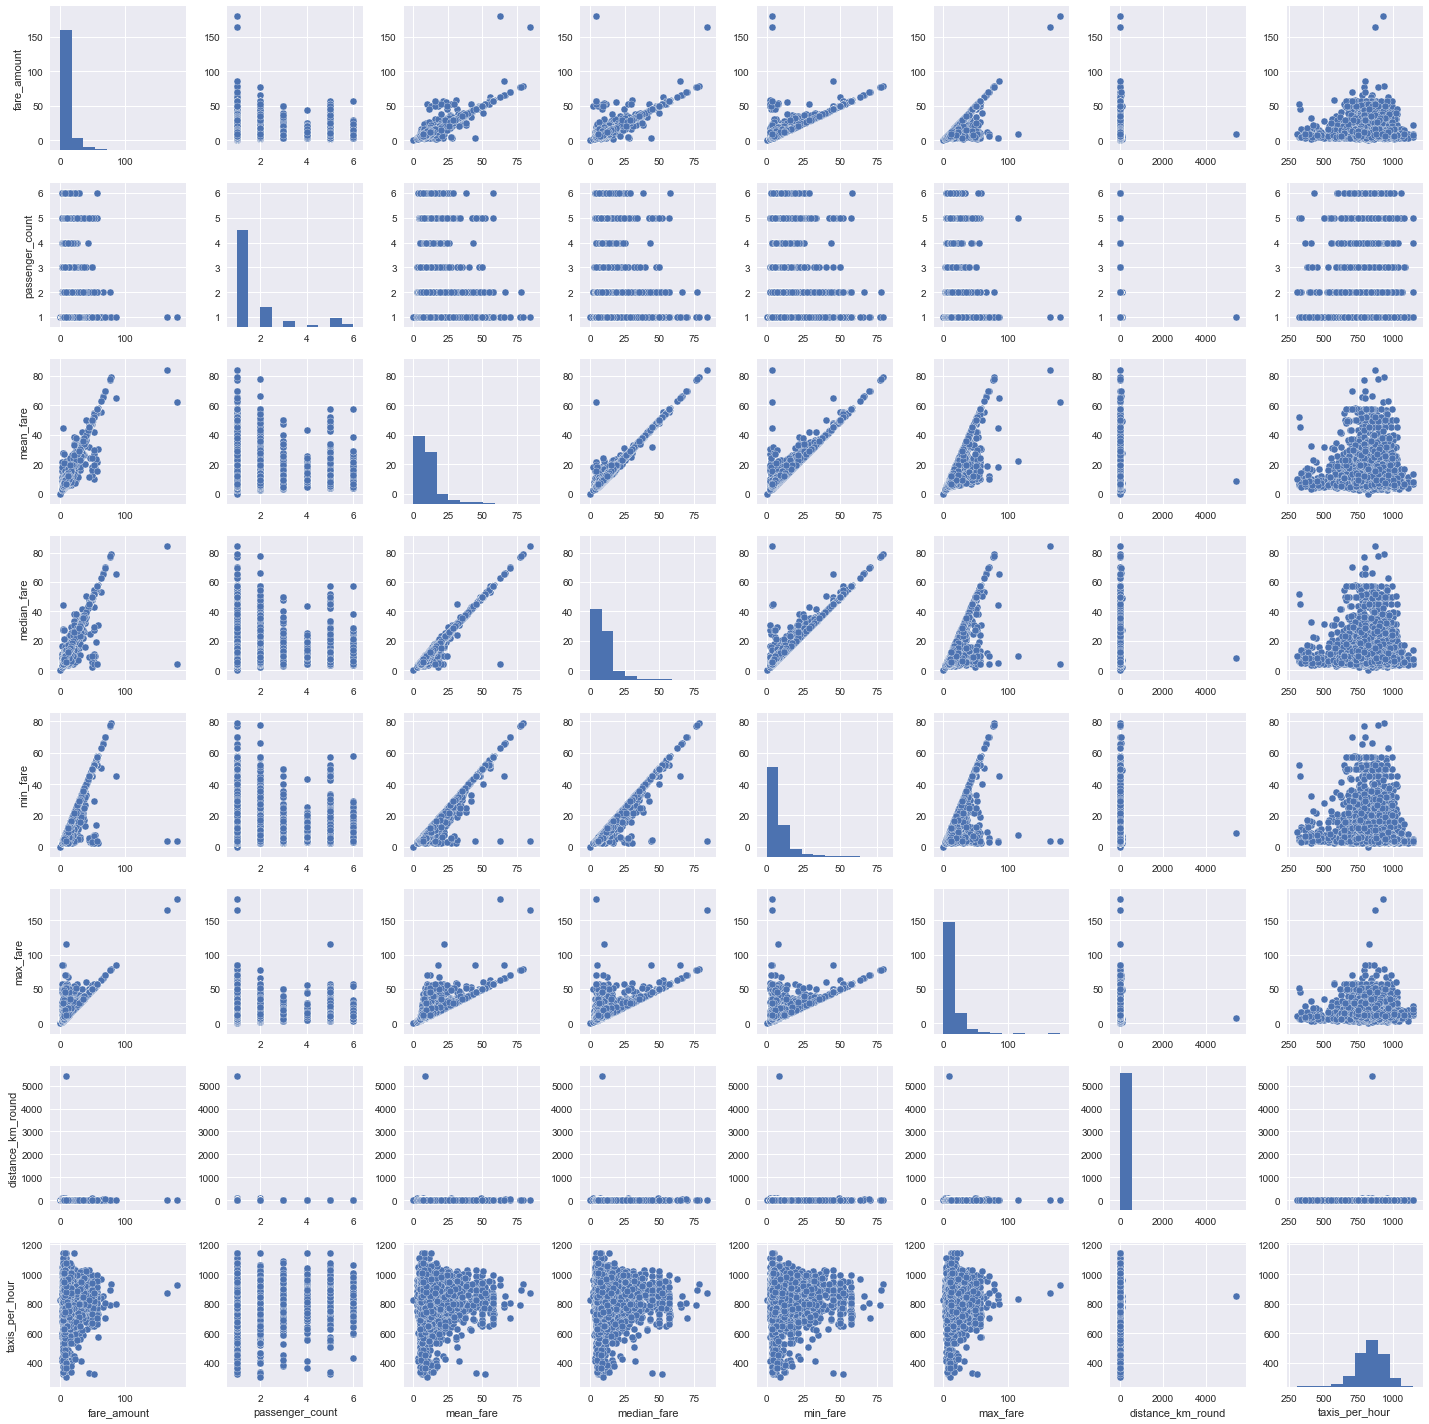

In [20]:
train_subset = train_df[:6000]
sns.pairplot(train_subset, vars=['fare_amount','passenger_count','mean_fare','median_fare','min_fare','max_fare','distance_km_round','taxis_per_hour'])
plt.show()

In [21]:
pd.set_option('float_format', '{:f}'.format) # prints the entire number instead of x + ye
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,...,distance_km_round,lon_diff,lat_diff,taxis_per_hour,mean_fare,median_fare,min_fare,max_fare,cost_per_km,geo_cluster
count,1953476.000000,1953476.000000,1953476.000000,1953476.000000,1953476.000000,1953476.000000,1953476.000000,1953476.000000,1953476.000000,1953476.000000,...,1953476.000000,1953476.000000,1953476.000000,1953476.000000,1953476.000000,1953476.000000,1953476.000000,1953476.000000,1953476.000000,1953476.000000
mean,11.323893,-72.958595,40.131252,-72.956192,40.128639,1.690533,2011.738460,6.269735,15.709049,13.508016,...,4.630129,0.001719,-0.002460,840.318420,11.348753,11.024547,9.177227,14.837421,0.442046,0.001752
std,9.733619,8.087140,5.373390,7.852067,8.472449,1.305494,1.865518,3.436875,8.681330,6.515093,...,87.255966,8.877370,9.488452,104.812347,9.211991,9.254288,9.403701,10.590656,12.294157,0.072352
min,0.010000,-3377.680908,-3458.664795,-3383.296631,-3461.540771,1.000000,2009.000000,1.000000,1.000000,0.000000,...,0.000000,-5448.387695,-5486.099609,48.000000,0.010000,0.010000,0.010000,0.010000,0.000000,0.000000
25%,6.000000,-73.992287,40.736477,-73.991592,40.735443,1.000000,2010.000000,3.000000,8.000000,9.000000,...,1.000000,-0.011513,-0.014027,781.000000,6.289474,6.000000,4.100000,9.000000,0.198020,0.000000
50%,8.500000,-73.982094,40.753304,-73.980606,40.753803,1.000000,2012.000000,6.000000,16.000000,14.000000,...,2.000000,0.000877,0.000000,850.000000,8.500000,8.100000,6.000000,12.000000,0.265487,0.000000
75%,12.500000,-73.968300,40.767506,-73.965294,40.768383,2.000000,2013.000000,9.000000,23.000000,19.000000,...,4.000000,0.013901,0.014305,911.000000,12.366667,12.000000,9.700000,16.500000,0.342466,0.000000
max,500.000000,2856.441650,2621.628418,3414.306641,3345.917236,6.000000,2015.000000,12.000000,31.000000,23.000000,...,17330.000000,4711.605957,4195.746582,1145.000000,495.000000,495.000000,495.000000,500.000000,3024.390381,3.000000


In [22]:
%%time

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_regression, RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from itertools import compress

target = train_df[['fare_amount']]
df = train_df.drop(['fare_amount', 'pickup_datetime'], axis=1)

X = df
y = target.values.ravel()

# Split X,y into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('>>> Train/Test Split done!')

# Create the 1st model using GradientBoostingRegressor
# gbr_model = GradientBoostingRegressor(n_estimators=25, random_state=7, learning_rate=0.1, max_depth=7) # with log1p/expm1: 0.514
# gbr_model.fit(X_train, np.log1p(y_train))
# print('>>> Model1 Training done!')

# Create the 2nd model using RandomForestRegressor
rfr_model = RandomForestRegressor(n_jobs=6, n_estimators=25, max_features=len(df.columns), max_depth=25, min_samples_split=3, min_samples_leaf=3, random_state=42)
rfr_model.fit(X_train, np.log1p(y_train))
print('>>> Model2 Training done!')

>>> Train/Test Split done!
>>> Model2 Training done!
Wall time: 1min 28s


# 4. Model Evaluation


>>> RMSE Score: 1.6677333802396535 



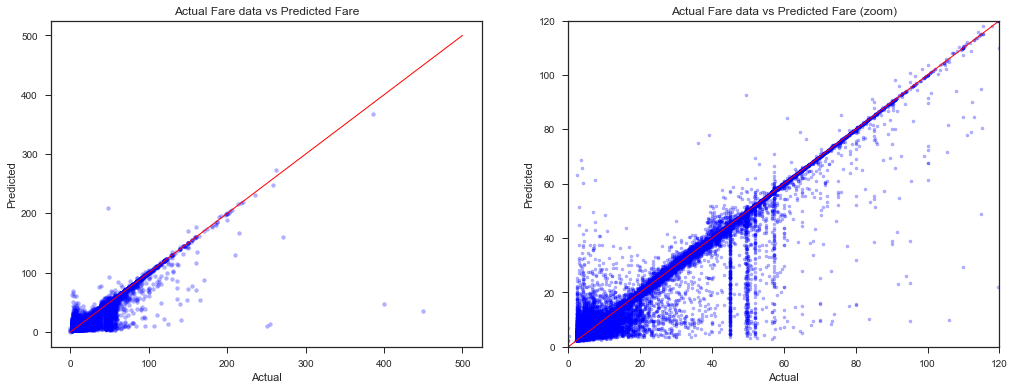

In [23]:
from lib import gfx  # gfx is another local module under the 'lib' directory
from sklearn import metrics
from math import sqrt

# The prediction is calculated as the arithmetic mean of both model's predictions
# gbr_fare = np.expm1(gbr_model.predict(X_test))  # model 1
rfr_fare = np.expm1(rfr_model.predict(X_test))   # model 2

# y_pred = (gbr_visitors + rfr_visitors) / 2
# y_pred = gbr_fare
y_pred = rfr_fare

rmse_score = sqrt(metrics.mean_squared_error(y_test, y_pred))
print('\n>>> RMSE Score:', rmse_score, '\n') # 1.669

# Plot Actual fare data against Predicted fare
gfx.plot_actual_vs_predicted(y, y_test, y_pred)

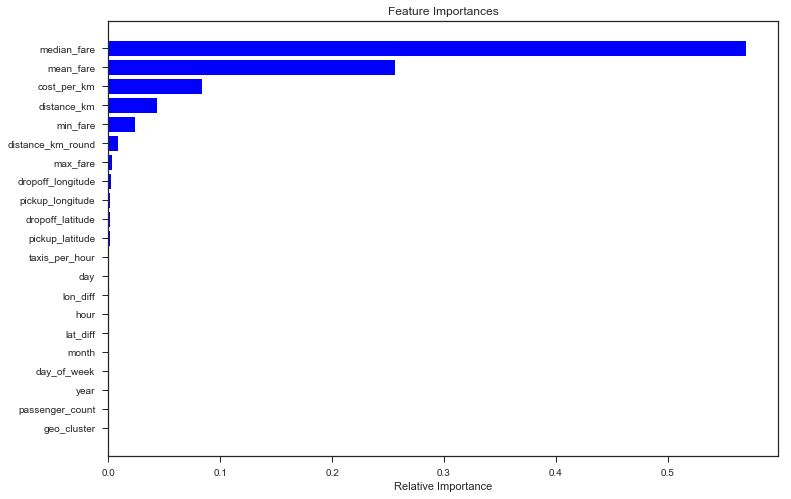

In [24]:
features = df.columns[:df.shape[1]]
importances = rfr_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# 5. Submission

### Feature Engineering for the Test dataset

In [25]:
# Add taxis_per_hour feature for the test set
def test_add_taxis_per_hour(test, train):
    short_train_df = train[['year','month','day','hour','taxis_per_hour']]
    tmp = short_train_df.groupby(['year','month','day','hour']).agg({'taxis_per_hour' : [np.mean]}).reset_index()
    tmp.columns = ['year','month','day','hour','taxis_per_hour']

    test = pd.merge(test, tmp, how='left', on=['year','month','day','hour'])  
    return test

In [26]:
# Add mean/median/min/max fare statistics for the test set
# ORIG CODE FOR TRAIN_DF
# tmp = df.groupby(['year','month','day_of_week','hour','distance_km_round','taxis_per_hour']).agg({'fare_amount' : [np.mean,np.median,np.min,np.max]}).reset_index()
# tmp.columns = ['year','month','day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']
# df = pd.merge(df, tmp, how='left', on=['year','month','day_of_week','hour','distance_km_round','taxis_per_hour']) 

def test_add_statistics(test, train):
    # Score 7.82    
#     short_train_df = train[['year','month','day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']]
#     tmp = short_train_df.groupby(['year','month','day_of_week','hour','distance_km_round','taxis_per_hour']).agg({'mean_fare':[np.mean],'median_fare':[np.mean],'min_fare':[np.mean],'max_fare':[np.mean]}).reset_index()
#     tmp.columns = ['year','month','day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']    
#     test = pd.merge(test, tmp, how='left', on=['year','month','day_of_week','hour','distance_km_round','taxis_per_hour'])          

    # Score 6.59
    short_train_df = train[['hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']]
    tmp = short_train_df.groupby(['hour','distance_km_round','taxis_per_hour']).agg({'mean_fare':[np.mean],'median_fare':[np.mean],'min_fare':[np.mean],'max_fare':[np.mean]}).reset_index()
    tmp.columns = ['hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']
    test = pd.merge(test, tmp, how='left', on=['hour','distance_km_round','taxis_per_hour'])  

    # Score 7.58
#     short_train_df = train[['day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']]
#     tmp = short_train_df.groupby(['day_of_week','hour','distance_km_round','taxis_per_hour']).agg({'mean_fare':[np.mean],'median_fare':[np.mean],'min_fare':[np.mean],'max_fare':[np.mean]}).reset_index()
#     tmp.columns = ['day_of_week','hour','distance_km_round','taxis_per_hour','mean_fare','median_fare','min_fare','max_fare']
#     test = pd.merge(test, tmp, how='left', on=['day_of_week','hour','distance_km_round','taxis_per_hour'])  
    
    return test

In [27]:
def test_add_cost_per_km(test):    
    test['cost_per_km'] = test.apply(lambda row: row['distance_km_round'] / row['mean_fare'], axis=1)
    test['cost_per_km'] = test['cost_per_km'].astype('float32')
    return test

### Load test data and add new features

In [28]:
# loads a sample submission file in the correct format (columns key and fare_amount). 
submission_df = pd.read_csv('data/sample_submission.csv')
# display(submission_df.head(2))

# loads the test dataset used for submission
test_df = pd.read_csv('data/test.csv')

display(test_df.head(3))
print('>>> test_df shape:', test_df.shape)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1


>>> test_df shape: (9914, 7)


In [29]:
# Add common features
test_df['pickup_datetime'] = test_df['pickup_datetime'].str.slice(0, 16)
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

test_df = add_calendar(test_df)
test_df = add_distance(test_df)
test_df = add_geo_cluster(test_df, train_df)
test_df = add_geo_diff(test_df)

display(test_df.head())

C:\Users\brcod\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,distance_km,distance_km_round,geo_cluster,lon_diff,lat_diff
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:00+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,13,1,2.323000,2,0,-0.008110,-0.019970
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:00+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,13,1,2.425000,2,0,-0.012024,0.019817
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:00+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,11,5,0.619000,1,0,0.002870,-0.005121
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:00+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,21,5,1.961000,2,0,-0.009288,-0.016172
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:00+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,21,5,5.387000,5,0,-0.022519,-0.045348


In [30]:
test_df = test_add_taxis_per_hour(test_df, train_df)        
display(test_df.head())

# Check missing data
print(test_df.isnull().sum())
test_df = test_df.fillna(test_df.mean())

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,distance_km,distance_km_round,geo_cluster,lon_diff,lat_diff,taxis_per_hour
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:00+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,13,1,2.323000,2,0,-0.008110,-0.019970,251.000000
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:00+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,13,1,2.425000,2,0,-0.012024,0.019817,251.000000
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:00+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,11,5,0.619000,1,0,0.002870,-0.005121,937.000000
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:00+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,21,5,1.961000,2,0,-0.009288,-0.016172,1056.000000
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:00+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,21,5,5.387000,5,0,-0.022519,-0.045348,1056.000000


key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
year                 0
month                0
day                  0
hour                 0
day_of_week          0
distance_km          0
distance_km_round    0
geo_cluster          0
lon_diff             0
lat_diff             0
taxis_per_hour       1
dtype: int64


In [31]:
test_df = test_add_statistics(test_df, train_df)        
display(test_df.head())

# Check missing data
print(test_df.isnull().sum())
test_df = test_df.fillna(test_df.mean())

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,...,distance_km,distance_km_round,geo_cluster,lon_diff,lat_diff,taxis_per_hour,mean_fare,median_fare,min_fare,max_fare
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:00+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,...,2.323000,2,0,-0.008110,-0.019970,251.000000,8.250000,8.750000,6.000000,9.500000
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:00+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,...,2.425000,2,0,-0.012024,0.019817,251.000000,8.250000,8.750000,6.000000,9.500000
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:00+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,...,0.619000,1,0,0.002870,-0.005121,937.000000,5.719512,5.485366,3.934146,8.617073
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:00+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,...,1.961000,2,0,-0.009288,-0.016172,1056.000000,8.321428,8.000000,4.500000,11.500000
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:00+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,...,5.387000,5,0,-0.022519,-0.045348,1056.000000,17.250000,17.250000,16.000000,18.500000


key                    0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
passenger_count        0
year                   0
month                  0
day                    0
hour                   0
day_of_week            0
distance_km            0
distance_km_round      0
geo_cluster            0
lon_diff               0
lat_diff               0
taxis_per_hour         0
mean_fare            253
median_fare          253
min_fare             253
max_fare             253
dtype: int64


In [32]:
test_df = test_add_cost_per_km(test_df)

In [33]:
display(test_df.head())

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,...,distance_km_round,geo_cluster,lon_diff,lat_diff,taxis_per_hour,mean_fare,median_fare,min_fare,max_fare,cost_per_km
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:00+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,...,2,0,-0.008110,-0.019970,251.000000,8.250000,8.750000,6.000000,9.500000,0.242424
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:00+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,...,2,0,-0.012024,0.019817,251.000000,8.250000,8.750000,6.000000,9.500000,0.242424
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:00+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,...,1,0,0.002870,-0.005121,937.000000,5.719512,5.485366,3.934146,8.617073,0.174840
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:00+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,...,2,0,-0.009288,-0.016172,1056.000000,8.321428,8.000000,4.500000,11.500000,0.240343
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:00+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,...,5,0,-0.022519,-0.045348,1056.000000,17.250000,17.250000,16.000000,18.500000,0.289855


In [38]:
import unittest

L1 = train_df.columns.tolist()
L2 = test_df.columns.tolist()
print('>>> Only *fare_amount* can show up as the difference between both datasets. Found:', list(set(L1) - set(L2)))

# tc = unittest.TestCase('__init__')
# tc.assertEqual((len(L1) == len(L2) and sorted(L1) == sorted(L2)), True)

>>> Only *fare_amount* can show up as the difference between both datasets. Found: ['fare_amount']


### Create the full model and use it to predict the fare

In [39]:
%%time

### Create model
rfr_model = RandomForestRegressor(n_jobs=6, n_estimators=25, max_features=len(df.columns), max_depth=25, min_samples_split=3, min_samples_leaf=3, random_state=42)

X = train_df.drop(['fare_amount', 'pickup_datetime'], axis=1)
y = train_df[['fare_amount']].values.ravel()
rfr_model.fit(X, np.log1p(y))

### Predict fare
X_test = test_df.drop(['key', 'pickup_datetime'], axis=1)
y_pred = np.expm1(rfr_model.predict(X_test))

### Save submission file
submission_df['fare_amount'] = y_pred
submission_df.to_csv('submission.csv', index=False)

display(submission_df.head())
print('>>> submission_df shape=', submission_df.shape)
print('>>> File saved sucessfully.')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,2.901731
1,2015-01-27 13:08:24.0000003,2.904335
2,2011-10-08 11:53:44.0000002,2.917538
3,2012-12-01 21:12:12.0000002,2.915998
4,2012-12-01 21:12:12.0000003,16.915974


>>> submission_df shape= (9914, 2)
>>> File saved sucessfully.
Wall time: 2min 11s


**Print total notebook runtime for debugging purposes:**

In [40]:
from datetime import timedelta

elapsed_time = (time.time() - start_time)
print('>>> Runtime:', str(timedelta(seconds=elapsed_time)))

>>> Runtime: 0:12:27.913799
